# Projeto Final - Classificação de Maçãs

## Matheus Lima da Cruz - 202100073219

### Objetivo
Implementar um sistema de classificação automática de maçãs utilizando técnicas de processamento de imagens.

### Técnicas Utilizadas:
1. **Filtros Espaciais**: Suavização Gaussiana e Detecção de Bordas (Sobel)
2. **Filtros Não Lineares**: Filtro de Mediana para remoção de ruído
3. **Morfologia Matemática**: Erosão, Dilatação, Abertura e Fechamento
4. **Transformada de Hough**: Detecção de círculos
5. **Métrica de Segmentação**: Segmentar imagens e classificar

---

## 1. Imports e Configurações

In [ ]:
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# Configurar matplotlib
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

## 2. Funções Auxiliares

In [ ]:
def rgb_para_cinza(img):
    """
    Converte RGB para Escala de Cinza.
    """
    if len(img.shape) == 2:
        return img
    return np.dot(img[...,:3], [0.299, 0.587, 0.114]).astype(np.uint8) # Converte para uint8 para manter a consistência de tipo de dados

In [ ]:
def filtro_mediana(img, k_size=3):
    """
    Filtro de Mediana
    Remove ruído impulsivo (sal e pimenta).
    """
    pad = k_size // 2 # Tamanho do padding para manter as dimensões da imagem
    img_padded = np.pad(img, pad, mode='edge') # Padding usando o valor da borda para evitar artefatos
    output = np.zeros_like(img) # Inicializa a imagem de saída com o mesmo formato da imagem de entrada
    
    for i in range(img.shape[0]): # Itera sobre cada pixel da imagem
        for j in range(img.shape[1]):
            janela = img_padded[i:i+k_size, j:j+k_size] # Extrai a janela de pixels ao redor do pixel atual
            output[i, j] = np.median(janela) # Calcula a mediana da janela e atribui ao pixel de saída correspondente
    
    return output.astype(np.uint8)

In [ ]:
def erosao(img_bin, k_size=3):
    """
    Erosão
    Remove pixels de borda, reduzindo objetos.
    """
    pad = k_size // 2 # Tamanho do padding para manter as dimensões da imagem
    img_padded = np.pad(img_bin, pad, mode='constant', constant_values=0) # Padding com zeros para evitar artefatos
    output = np.zeros_like(img_bin) # Inicializa a imagem de saída com o mesmo formato da imagem de entrada
    
    for i in range(img_bin.shape[0]): # Itera sobre cada pixel da imagem binária
        for j in range(img_bin.shape[1]):
            janela = img_padded[i:i+k_size, j:j+k_size] # Extrai a janela de pixels ao redor do pixel atual
            output[i, j] = np.min(janela) # Calcula o mínimo da janela e atribui ao pixel de saída correspondente
    
    return output.astype(np.uint8)


def dilatacao(img_bin, k_size=3):
    """
    Dilatação
    Adiciona pixels de borda, expandindo objetos.
    """
    pad = k_size // 2 # Tamanho do padding para manter as dimensões da imagem
    img_padded = np.pad(img_bin, pad, mode='constant', constant_values=0) # Padding com zeros para evitar artefatos
    output = np.zeros_like(img_bin) # Inicializa a imagem de saída com o mesmo formato da imagem de entrada
    
    for i in range(img_bin.shape[0]): # Itera sobre cada pixel da imagem binária
        for j in range(img_bin.shape[1]): 
            janela = img_padded[i:i+k_size, j:j+k_size] # Extrai a janela de pixels ao redor do pixel atual
            output[i, j] = np.max(janela) # Calcula o máximo da janela e atribui ao pixel de saída correspondente
    
    return output.astype(np.uint8)


def abertura(img, k_size=3):
    """
    Abertura = Erosão + Dilatação
    Remove pequenos objetos, suaviza contornos
    """
    return dilatacao(erosao(img, k_size), k_size)


def fechamento(img, k_size=3):
    """
    Fechamento = Dilatação + Erosão
    Preenche buracos, conecta regiões próximas
    """
    return erosao(dilatacao(img, k_size), k_size)

In [ ]:
def hough_circulos_gradiente(img_borda, img_orientacao, raios_intervalo, 
                              limiar_votos=0.35, distancia_minima=30):
    """
    Transformada de Hough Circular.
    Usa informação de gradiente para votar apenas na direção perpendicular à borda.
    
    Parâmetros:
        img_borda: Imagem binária com bordas detectadas
        img_orientacao: Ângulo do gradiente em cada ponto (radianos)
        raios_intervalo: Range de raios para testar
        limiar_votos: Fração do máximo de votos (0.0 a 1.0)
        distancia_minima: Distância mínima entre centros detectados
    
    Retorna:
        Lista de tuplas: [(x, y, raio, votos), ...]
    """
    H, W = img_borda.shape # Dimensões da imagem
    raios_lista = list(raios_intervalo) # Lista de raios a serem testados
    
    # Acumulador 3D
    acumulador = np.zeros((H, W, len(raios_lista)), dtype=np.uint32) # Usar uint32 para evitar overflow de votos
    
    # Pixels de borda
    y_idxs, x_idxs = np.nonzero(img_borda) # Índices dos pixels onde há borda
    
    # Votar para cada ponto de borda
    for i in range(len(y_idxs)): # Itera sobre cada pixel de borda
        y, x = y_idxs[i], x_idxs[i] # Coordenadas do pixel de borda
        theta = img_orientacao[y, x] # Ângulo do gradiente no pixel de borda
        
        sin_t = np.sin(theta) # Seno do ângulo para calcular a direção do gradiente
        cos_t = np.cos(theta) # Cosseno do ângulo para calcular a direção do gradiente
        
        for r_idx, r in enumerate(raios_lista): # Itera sobre cada raio a ser testado
            # Direção do gradiente
            a1 = int(round(x - r * cos_t)) 
            b1 = int(round(y - r * sin_t))
            
            # Direção oposta
            a2 = int(round(x + r * cos_t))
            b2 = int(round(y + r * sin_t))
            
            # Votar se dentro dos limites
            if 0 <= b1 < H and 0 <= a1 < W:
                acumulador[b1, a1, r_idx] += 1
            if 0 <= b2 < H and 0 <= a2 < W:
                acumulador[b2, a2, r_idx] += 1
    
    # Encontrar máximos
    voto_maximo = np.max(acumulador)

    # Se o voto máximo for zero, não há círculos detectados
    if voto_maximo == 0:
        return []
    
    limiar = int(voto_maximo * limiar_votos) # Limiar absoluto baseado na fração do voto máximo
    
    # Extrair candidatos
    y_c, x_c, r_idx = np.where(acumulador >= limiar)
    
    # Criar lista de círculos com votos
    circulos = []
    for i in range(len(y_c)): # Itera sobre cada candidato encontrado
        votos = acumulador[y_c[i], x_c[i], r_idx[i]] # Número de votos para o candidato atual
        circulos.append((x_c[i], y_c[i], raios_lista[r_idx[i]], votos)) # Adiciona o círculo à lista com suas coordenadas, raio e votos
    
    # Ordenar por votos
    circulos.sort(key=lambda x: x[3], reverse=True)
    
    # Non-Maximum Suppression
    circulos_nms = []
    for circulo in circulos: # Itera sobre os círculos ordenados por votos
        x, y, r, v = circulo # Coordenadas, raio e votos do círculo atual
        
        muito_proximo = False # Flag para verificar se o círculo atual está muito próximo de um já selecionado
        for (xf, yf, rf, _) in circulos_nms: # Itera sobre os círculos já selecionados para verificar a distância
            dist = np.sqrt((x - xf)**2 + (y - yf)**2) # Calcula a distância entre os centros dos círculos
            if dist < distancia_minima: # Se a distância for menor que a distância mínima, considera os círculos como muito próximos e não seleciona o círculo atual
                muito_proximo = True
                break
        
        if not muito_proximo: # Se o círculo atual não estiver muito próximo de nenhum já selecionado, adiciona à lista final de círculos
            circulos_nms.append(circulo)
    
    return circulos_nms

In [ ]:
def classificar_maca(img_rgb, circulo):
    """
    Classifica a maçã comparando os canais R e G.
    """
    xc, yc, r, votos = circulo # Desempacota as coordenadas do centro, raio e votos do círculo
    xc, yc, r = int(xc), int(yc), int(r)
    
    # 1. Criar Máscara e Extrair Pixels
    mascara = np.zeros((img_rgb.shape[0], img_rgb.shape[1]), dtype=np.uint8) # Máscara binária para a região do círculo
    Y, X = np.ogrid[:img_rgb.shape[0], :img_rgb.shape[1]] # Gera coordenadas de grade para a imagem
    dist_from_center = np.sqrt((X - xc)**2 + (Y - yc)**2) # Calcula a distância de cada pixel ao centro do círculo
    mascara[dist_from_center <= r] = 1 # Define a máscara para os pixels dentro do círculo
    pixels_maca = img_rgb[mascara == 1] # Extrai os pixels da região do círculo usando a máscara
    
    # Verificar se há pixels para evitar divisão por zero
    if len(pixels_maca) == 0:
        return "Indefinido", 0, 0
    
    # 2. Calcular as Médias
    media_r = np.mean(pixels_maca[:, 0])
    media_g = np.mean(pixels_maca[:, 1])
    
    # 3. Métrica de Segmentação: Índice de Cor Normalizado
    # Essa métrica varia de -1 (Totalmente Vermelho) a +1 (Totalmente Verde)
    # Fórmula: (G - R) / (G + R)
    soma = media_g + media_r # Soma para normalizar a diferença entre os canais
    if soma == 0: 
        indice_cor = 0 
    else:
        indice_cor = (media_g - media_r) / soma
    
    # 4. Regra de Decisão Ajustada
    # Se o índice for positivo (> 0), significa que G > R -> Verde
    # Se o índice for negativo (< 0), significa que R > G -> Vermelha
    if indice_cor > 0:
        return "Verde", media_r, media_g
    else:
        return "Madura (Vermelha)", media_r, media_g

## 3. Pipeline de Processamento

### Etapas:
1. Carregar imagem e converter para cinza
2. Aplicar Filtro de Mediana (redução de ruído)
3. Aplicar Suavização Gaussiana
4. Detectar bordas com Sobel
5. Aplicar Morfologia Matemática
6. Detectar círculos com Hough
7. Classificar Maçã

In [ ]:
# ========================================
# CONFIGURAÇÕES
# ========================================

# Caminho da imagem
caminho = './images/vermelha.jpg'

# Parâmetros de detecção
RAIO_MIN = 32       # Raio mínimo esperado (pixels)
RAIO_MAX = 40     # Raio máximo esperado (pixels)
LIMIAR_SOBEL = 40   # Limiar para binarização de bordas (0-255)

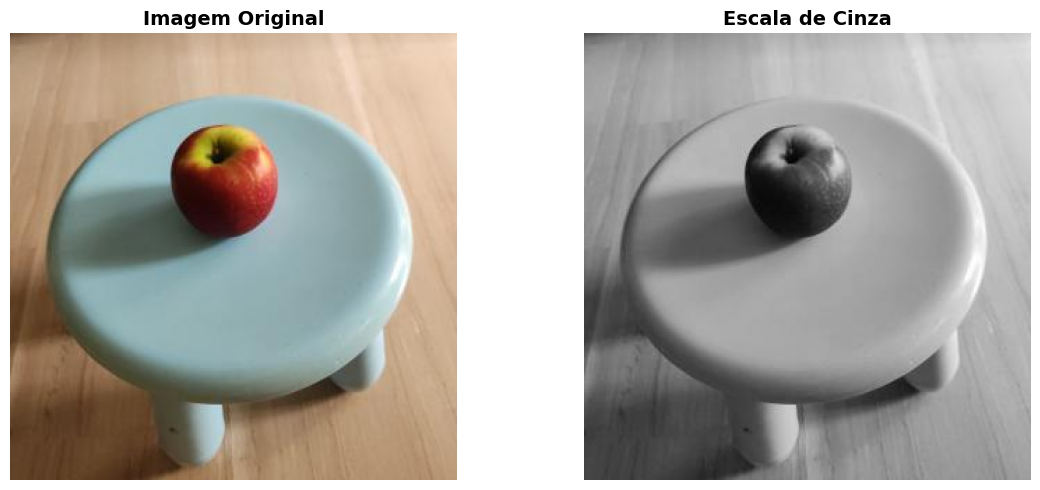

In [ ]:
# ========================================
# ETAPA 1: Carregar e Converter para Cinza
# ========================================
img_orig = imread(caminho)
img_gray = rgb_para_cinza(img_orig)

# Visualizar
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(img_orig)
ax1.set_title('Imagem Original', fontsize=14, weight='bold')
ax1.axis('off')

ax2.imshow(img_gray, cmap='gray')
ax2.set_title('Escala de Cinza', fontsize=14, weight='bold')
ax2.axis('off')

plt.tight_layout()
plt.show()

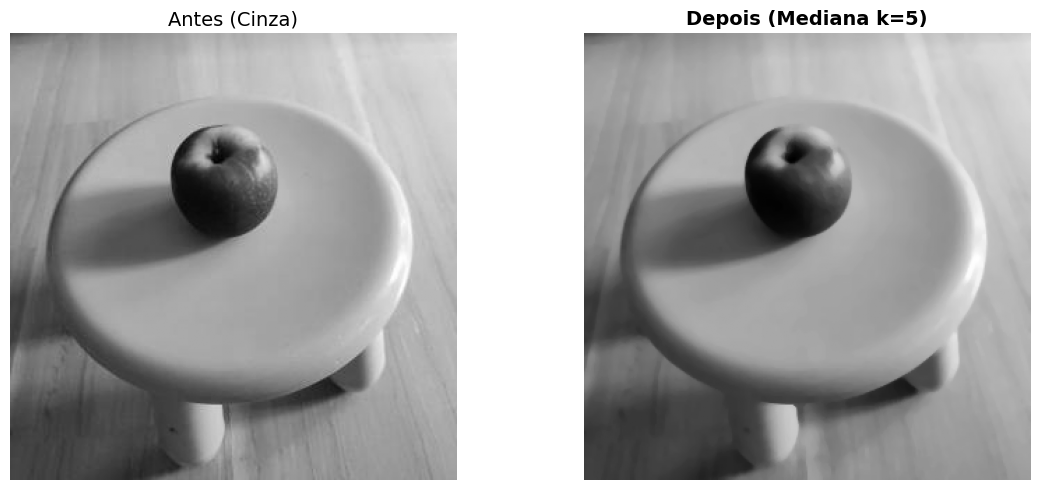

In [ ]:
# ========================================
# ETAPA 2: Filtro de Mediana
# ========================================
img_mediana = filtro_mediana(img_gray, k_size=5)

# Comparar antes e depois
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(img_gray, cmap='gray')
ax1.set_title('Antes (Cinza)', fontsize=14)
ax1.axis('off')

ax2.imshow(img_mediana, cmap='gray')
ax2.set_title('Depois (Mediana k=5)', fontsize=14, weight='bold')
ax2.axis('off')

plt.tight_layout()
plt.show()

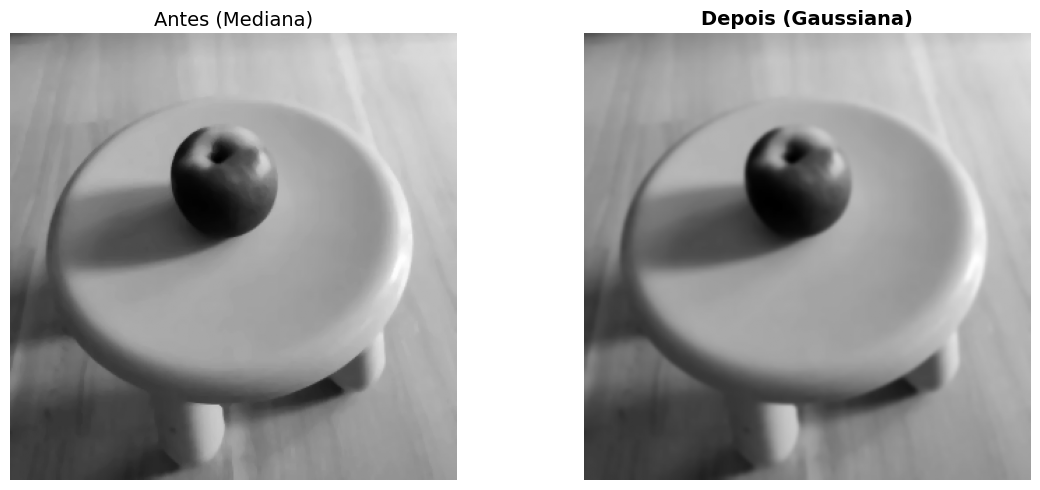

In [ ]:
# ========================================
# ETAPA 3: Suavização Gaussiana
# ========================================

# Kernel Gaussiano 5x5 aproximado
kernel_gauss = np.array([
    [1,  4,  7,  4, 1],
    [4, 16, 26, 16, 4],
    [7, 26, 41, 26, 7],
    [4, 16, 26, 16, 4],
    [1,  4,  7,  4, 1]
]) / 273.0

img_suave = convolve2d(img_mediana, kernel_gauss, mode='same', boundary='symm')

# Visualizar
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(img_mediana, cmap='gray')
ax1.set_title('Antes (Mediana)', fontsize=14)
ax1.axis('off')

ax2.imshow(img_suave, cmap='gray')
ax2.set_title('Depois (Gaussiana)', fontsize=14, weight='bold')
ax2.axis('off')

plt.tight_layout()
plt.show()

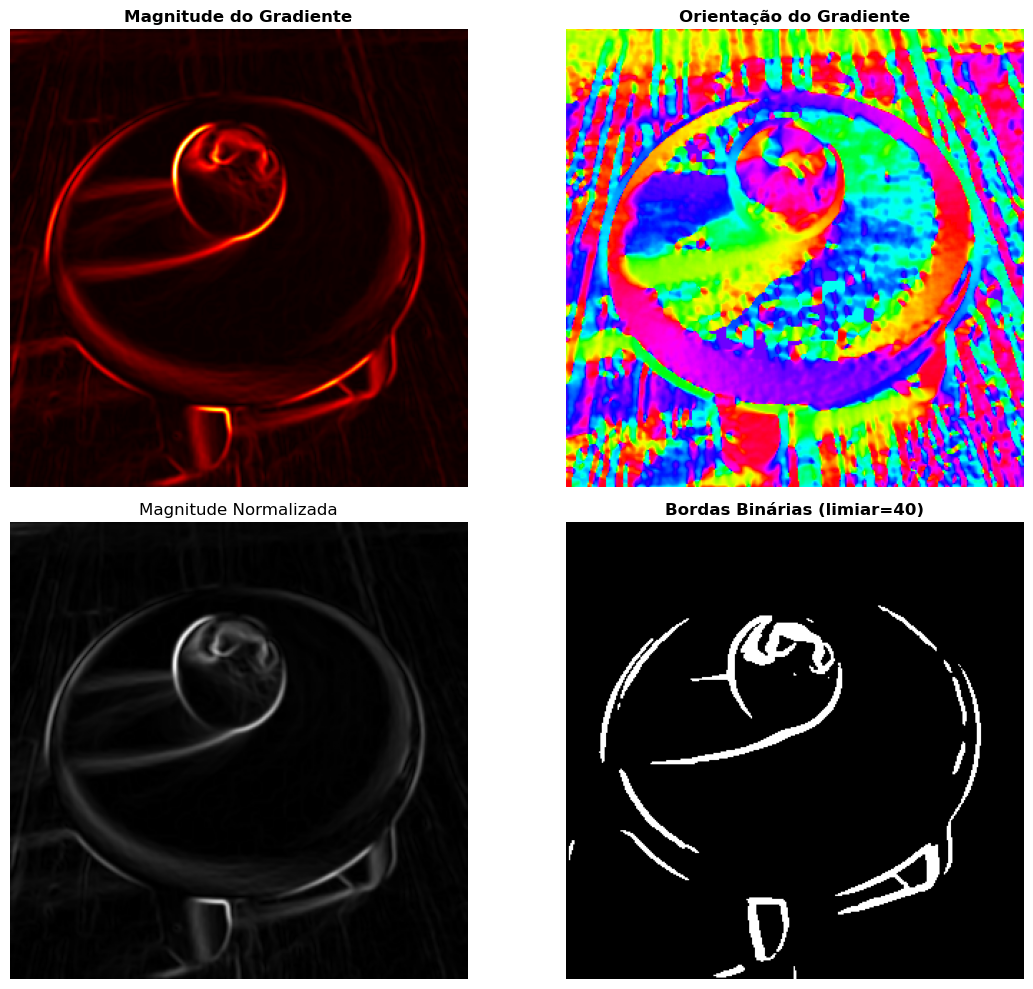

In [ ]:
# ========================================
# ETAPA 4: Detecção de Bordas (Sobel)
# ========================================

# Kernels Sobel
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

# Calcular gradientes
grad_x = convolve2d(img_suave, sobel_x, mode='same', boundary='symm')
grad_y = convolve2d(img_suave, sobel_y, mode='same', boundary='symm')

# Magnitude e Orientação
magnitude = np.sqrt(grad_x**2 + grad_y**2)
orientacao = np.arctan2(grad_y, grad_x)

# Normalizar e binarizar
magnitude_norm = (magnitude / magnitude.max()) * 255
img_bordas = (magnitude_norm > LIMIAR_SOBEL).astype(np.uint8)

# Visualizar
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0,0].imshow(magnitude, cmap='hot')
axes[0,0].set_title('Magnitude do Gradiente', fontsize=12, weight='bold')
axes[0,0].axis('off')

axes[0,1].imshow(orientacao, cmap='hsv')
axes[0,1].set_title('Orientação do Gradiente', fontsize=12, weight='bold')
axes[0,1].axis('off')

axes[1,0].imshow(magnitude_norm, cmap='gray')
axes[1,0].set_title('Magnitude Normalizada', fontsize=12)
axes[1,0].axis('off')

axes[1,1].imshow(img_bordas, cmap='gray')
axes[1,1].set_title(f'Bordas Binárias (limiar={LIMIAR_SOBEL})', fontsize=12, weight='bold')
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

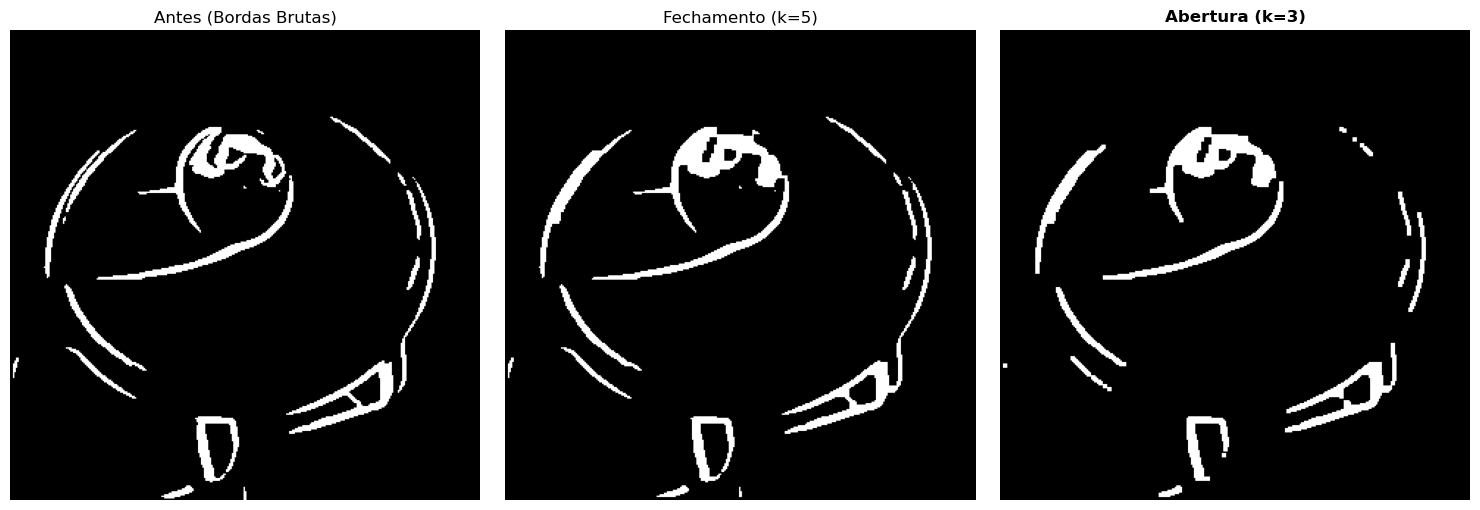

In [ ]:
# ========================================
# ETAPA 5: Morfologia Matemática
# ========================================
# Fechamento: preenche buracos
img_fechamento = fechamento(img_bordas, k_size=5)

# Abertura: remove ruído
img_morf = abertura(img_fechamento, k_size=3)

# Visualizar
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img_bordas, cmap='gray')
axes[0].set_title('Antes (Bordas Brutas)', fontsize=12)
axes[0].axis('off')

axes[1].imshow(img_fechamento, cmap='gray')
axes[1].set_title('Fechamento (k=5)', fontsize=12)
axes[1].axis('off')

axes[2].imshow(img_morf, cmap='gray')
axes[2].set_title('Abertura (k=3)', fontsize=12, weight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# ========================================
# ETAPA 6: Transformada de Hough
# ========================================

print("\n Aplicando Transformada de Hough para Círculos...")

# Range de raios
raios = range(RAIO_MIN, RAIO_MAX, 3)

# Detectar círculos
circulos = hough_circulos_gradiente(
    img_morf, 
    orientacao, 
    raios,
    limiar_votos=0.5,
    distancia_minima=int(RAIO_MAX*1.2)
)

print(f"\n{'='*60}")
print(f"RESULTADO: {len(circulos)} maçã(s) detectada(s)!")
print(f"{'='*60}")

if circulos:
    print("\nDetalhes:")
    for i, (x, y, r, votos) in enumerate(circulos, 1):
        print(f"  Maçã {i}: Centro=({x}, {y}), Raio={r}px, Votos={votos}")
else:
    print("\n⚠️  Nenhuma maçã detectada!")
    print("Tente ajustar:")
    print("  - RAIO_MIN e RAIO_MAX")
    print("  - LIMIAR_SOBEL")
    print("  - limiar_votos na função hough_circulos_gradiente")


 Aplicando Transformada de Hough para Círculos...

RESULTADO: 1 maçã(s) detectada(s)!

Detalhes:
  Maçã 1: Centro=(151, 101), Raio=38px, Votos=25


## 4. Visualização Final

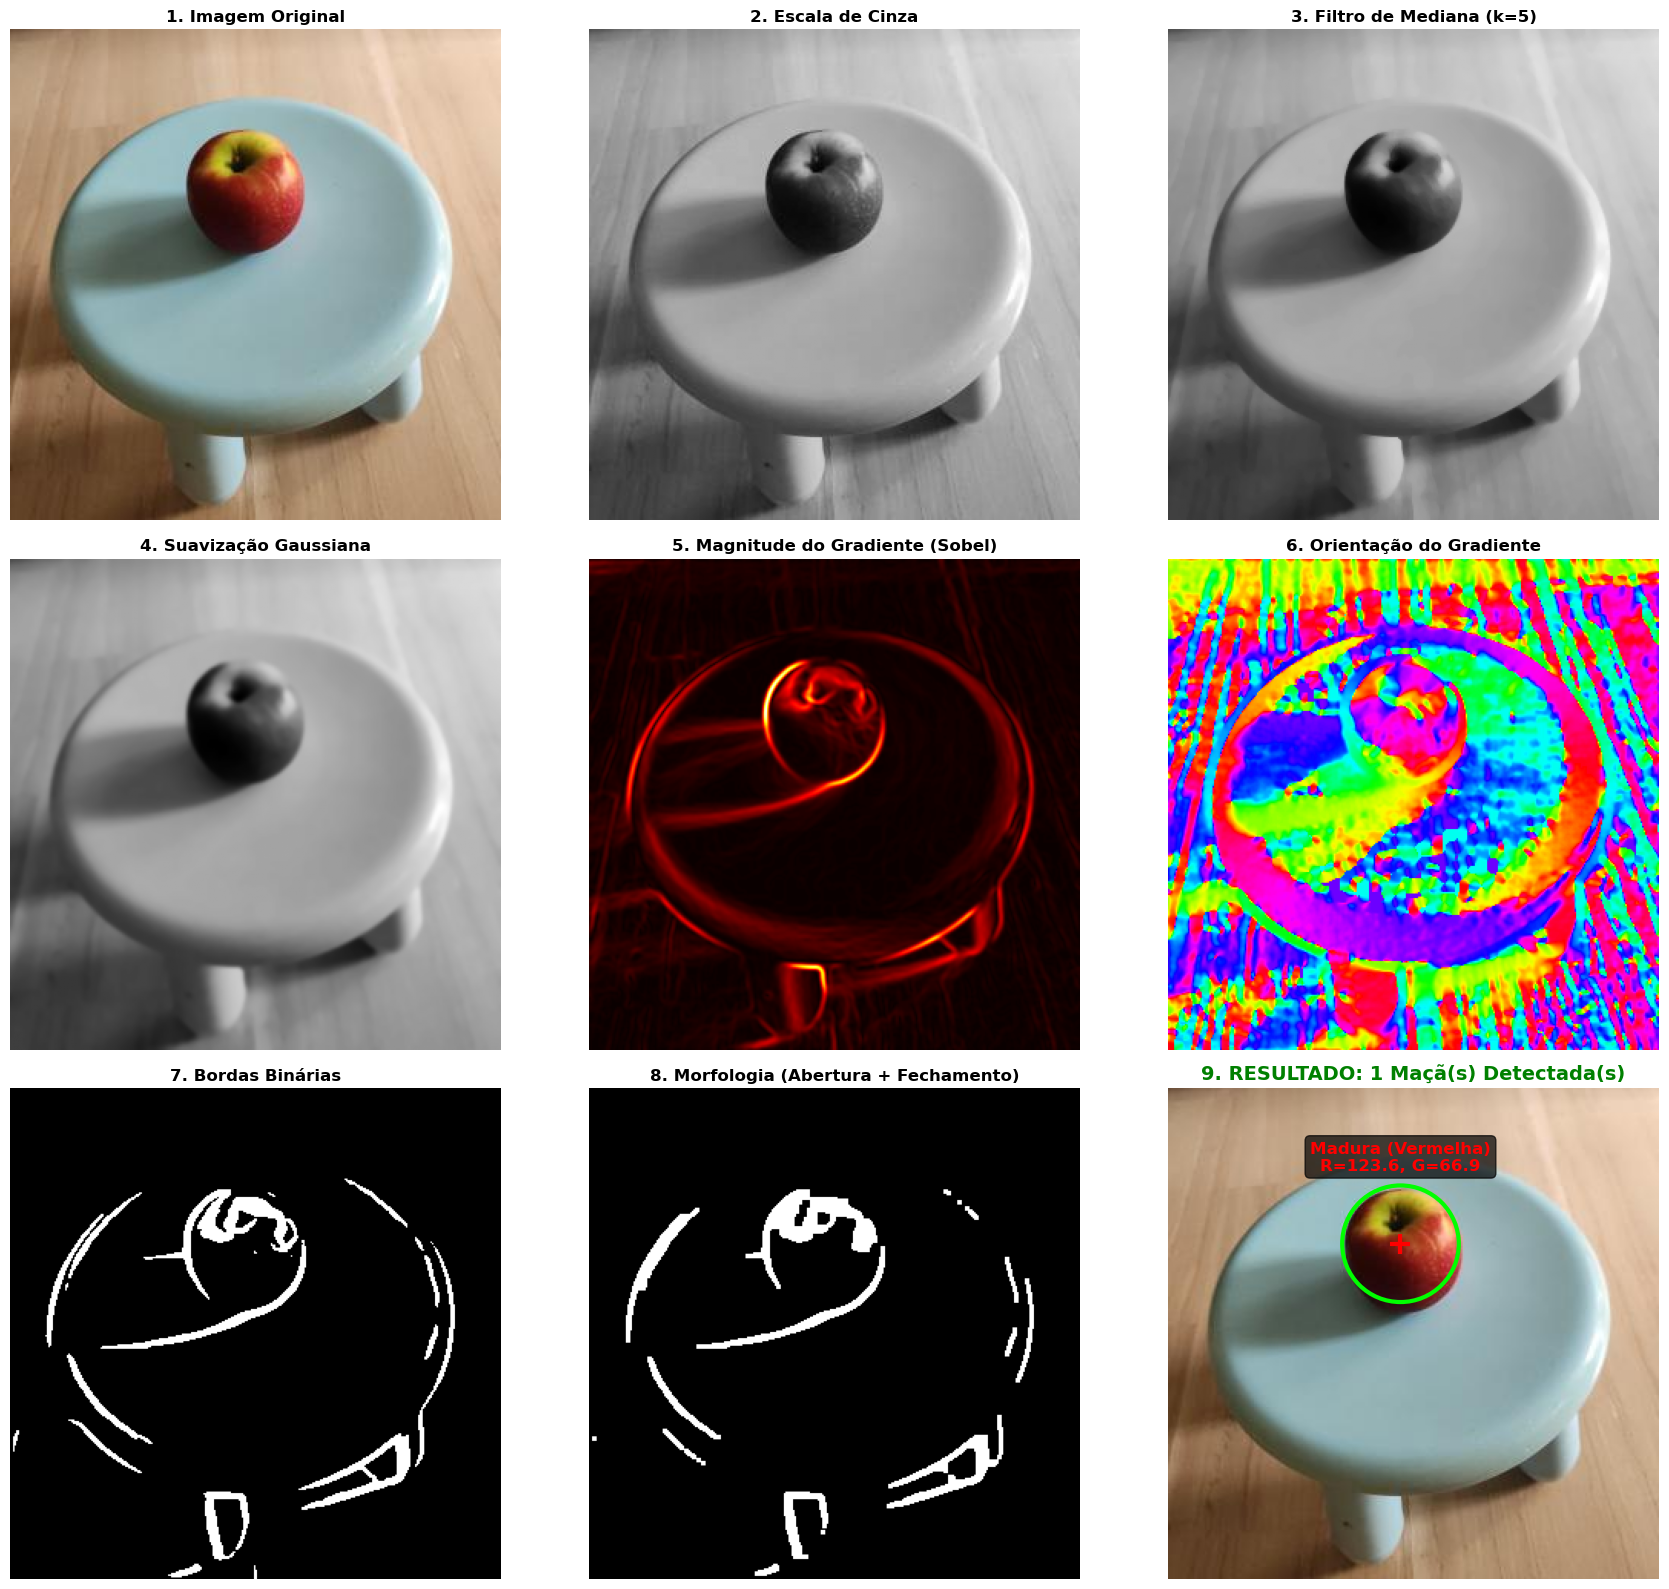

In [ ]:
# ========================================
# PIPELINE
# ========================================

fig, axes = plt.subplots(3, 3, figsize=(18, 16))
axes = axes.flatten()

# 1. Original
axes[0].imshow(img_orig)
axes[0].set_title('1. Imagem Original', fontsize=12, weight='bold')

# 2. Escala de Cinza
axes[1].imshow(img_gray, cmap='gray')
axes[1].set_title('2. Escala de Cinza', fontsize=12, weight='bold')

# 3. Filtro Mediana
axes[2].imshow(img_mediana, cmap='gray')
axes[2].set_title('3. Filtro de Mediana (k=5)', fontsize=12, weight='bold')

# 4. Suavização Gaussiana
axes[3].imshow(img_suave, cmap='gray')
axes[3].set_title('4. Suavização Gaussiana', fontsize=12, weight='bold')

# 5. Magnitude do Gradiente
axes[4].imshow(magnitude, cmap='hot')
axes[4].set_title('5. Magnitude do Gradiente (Sobel)', fontsize=12, weight='bold')

# 6. Orientação do Gradiente
axes[5].imshow(orientacao, cmap='hsv')
axes[5].set_title('6. Orientação do Gradiente', fontsize=12, weight='bold')

# 7. Bordas Binárias
axes[6].imshow(img_bordas, cmap='gray')
axes[6].set_title('7. Bordas Binárias', fontsize=12, weight='bold')

# 8. Morfologia
axes[7].imshow(img_morf, cmap='gray')
axes[7].set_title('8. Morfologia (Abertura + Fechamento)', fontsize=12, weight='bold')

# 9. Resultado Final
axes[8].imshow(img_orig)
if circulos:
    for (x, y, r, votos) in circulos:
        # Desenhar círculo
        circle = plt.Circle((x, y), r, color='lime', fill=False, linewidth=3)
        axes[8].add_patch(circle)

        # Marcar centro
        axes[8].plot(x, y, 'r+', markersize=15, markeredgewidth=3)

        # Classificação
        resultado, r_val, g_val = classificar_maca(img_orig, (x, y, r, votos))
        cor_texto = 'lime' if "Verde" in resultado else 'red'
        axes[8].text(x, y-r-10, f'{resultado}\nR={r_val:.1f}, G={g_val:.1f}',
                     color=cor_texto, fontsize=12, weight='bold',
                     bbox=dict(boxstyle='round', facecolor='black', alpha=0.7),
                     ha='center')

axes[8].set_title(f'9. RESULTADO: {len(circulos)} Maçã(s) Detectada(s)',
                 fontsize=14, weight='bold', color='green')

# Remover eixos
for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.savefig('resultado_deteccao_pipeline.png', dpi=150, bbox_inches='tight')
plt.show()